In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [26]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included


In [27]:
file_path = r"C:\Users\trush\OneDrive\Documents\WFU Grad School Info\BAN 6025 Machine Learning\Data\airbnb_cleaned.csv"
airbnb_df = pd.read_csv(file_path)
airbnb_df.head()

,host_since,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,amenities,...,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_no_refunds,cancellation_policy_strict,cancellation_policy_super_strict_30
0,2011.0,0,1.0,1,0,6,2.5,1.0,3.0,17,...,False,False,False,False,True,False,True,False,False,False
1,2015.0,0,1.0,1,1,2,0.0,1.0,1.0,6,...,False,False,True,False,False,False,True,False,False,False
2,2015.0,0,1.0,1,0,2,1.0,1.0,1.0,15,...,False,False,False,False,True,True,False,False,False,False
3,2014.0,0,1.0,1,1,2,1.0,1.0,1.0,18,...,False,False,False,False,True,False,True,False,False,False
4,2015.0,0,1.0,1,0,2,1.0,1.0,1.0,12,...,False,False,False,False,True,False,False,False,True,False


In [28]:
airbnb_df = airbnb_df.replace({True: 1, False: 0})

C:\Users\trush\AppData\Local\Temp\ipykernel_27676\3257083724.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  airbnb_df = airbnb_df.replace({True: 1, False: 0})


In [29]:
columns = airbnb_df.columns.values.tolist()
scaler = StandardScaler()

airbnb_df_scaled = scaler.fit_transform(airbnb_df.to_numpy())
airbnb_df_scaled = pd.DataFrame(airbnb_df, columns=columns)

In [30]:
X = airbnb_df_scaled.drop(columns=['price'])
y = airbnb_df_scaled['price']
X = sm.add_constant(X)

logistic_regression_full = sm.OLS(y, X).fit()

print(logistic_regression_full.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     29.65
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:26:29   Log-Likelihood:                -33845.
No. Observations:                4751   AIC:                         6.794e+04
Df Residuals:                    4626   BIC:                         6.875e+04
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [31]:
stepwise_variables = stepwise_selection(X, y)

Add  bathrooms with p-value 0.0000
Add  has_availability with p-value 0.0000
Add  bedrooms with p-value 0.0000
Add  neighbourhood_Old Enfield with p-value 0.0000
Add  host_identity_verified with p-value 0.0000
Add  neighbourhood_Tarrytown with p-value 0.0000
Add  room_type_Entire home/apt with p-value 0.0000
Add  number_of_reviews with p-value 0.0000
Add  guests_included with p-value 0.0000
Add  neighbourhood_Bryker Woods with p-value 0.0000
Add  extra_people with p-value 0.0000
Add  neighbourhood_Rainey Street with p-value 0.0000
Add  neighbourhood_Travis Heights with p-value 0.0001
Add  cancellation_policy_moderate with p-value 0.0002
Add  neighbourhood_Old West Austin with p-value 0.0004
Add  neighbourhood_Zilker with p-value 0.0008
Add  neighbourhood_East Downtown with p-value 0.0003
Add  neighbourhood_Clarksville with p-value 0.0017
Add  accommodates with p-value 0.0020
Add  property_type_Tent with p-value 0.0012
Add  host_is_superhost with p-value 0.0016
Add  property_type_Townho

In [32]:
X_step = airbnb_df_scaled[stepwise_variables]
y_step = airbnb_df_scaled['price']
X_step = sm.add_constant(X_step)

lr_step = sm.OLS(y_step, X_step).fit()

print(lr_step.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     122.7
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:27:19   Log-Likelihood:                -33900.
No. Observations:                4751   AIC:                         6.786e+04
Df Residuals:                    4721   BIC:                         6.805e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
bathrooms     

In [35]:
stepwise_df = pd.concat([X_step, y], axis=1)

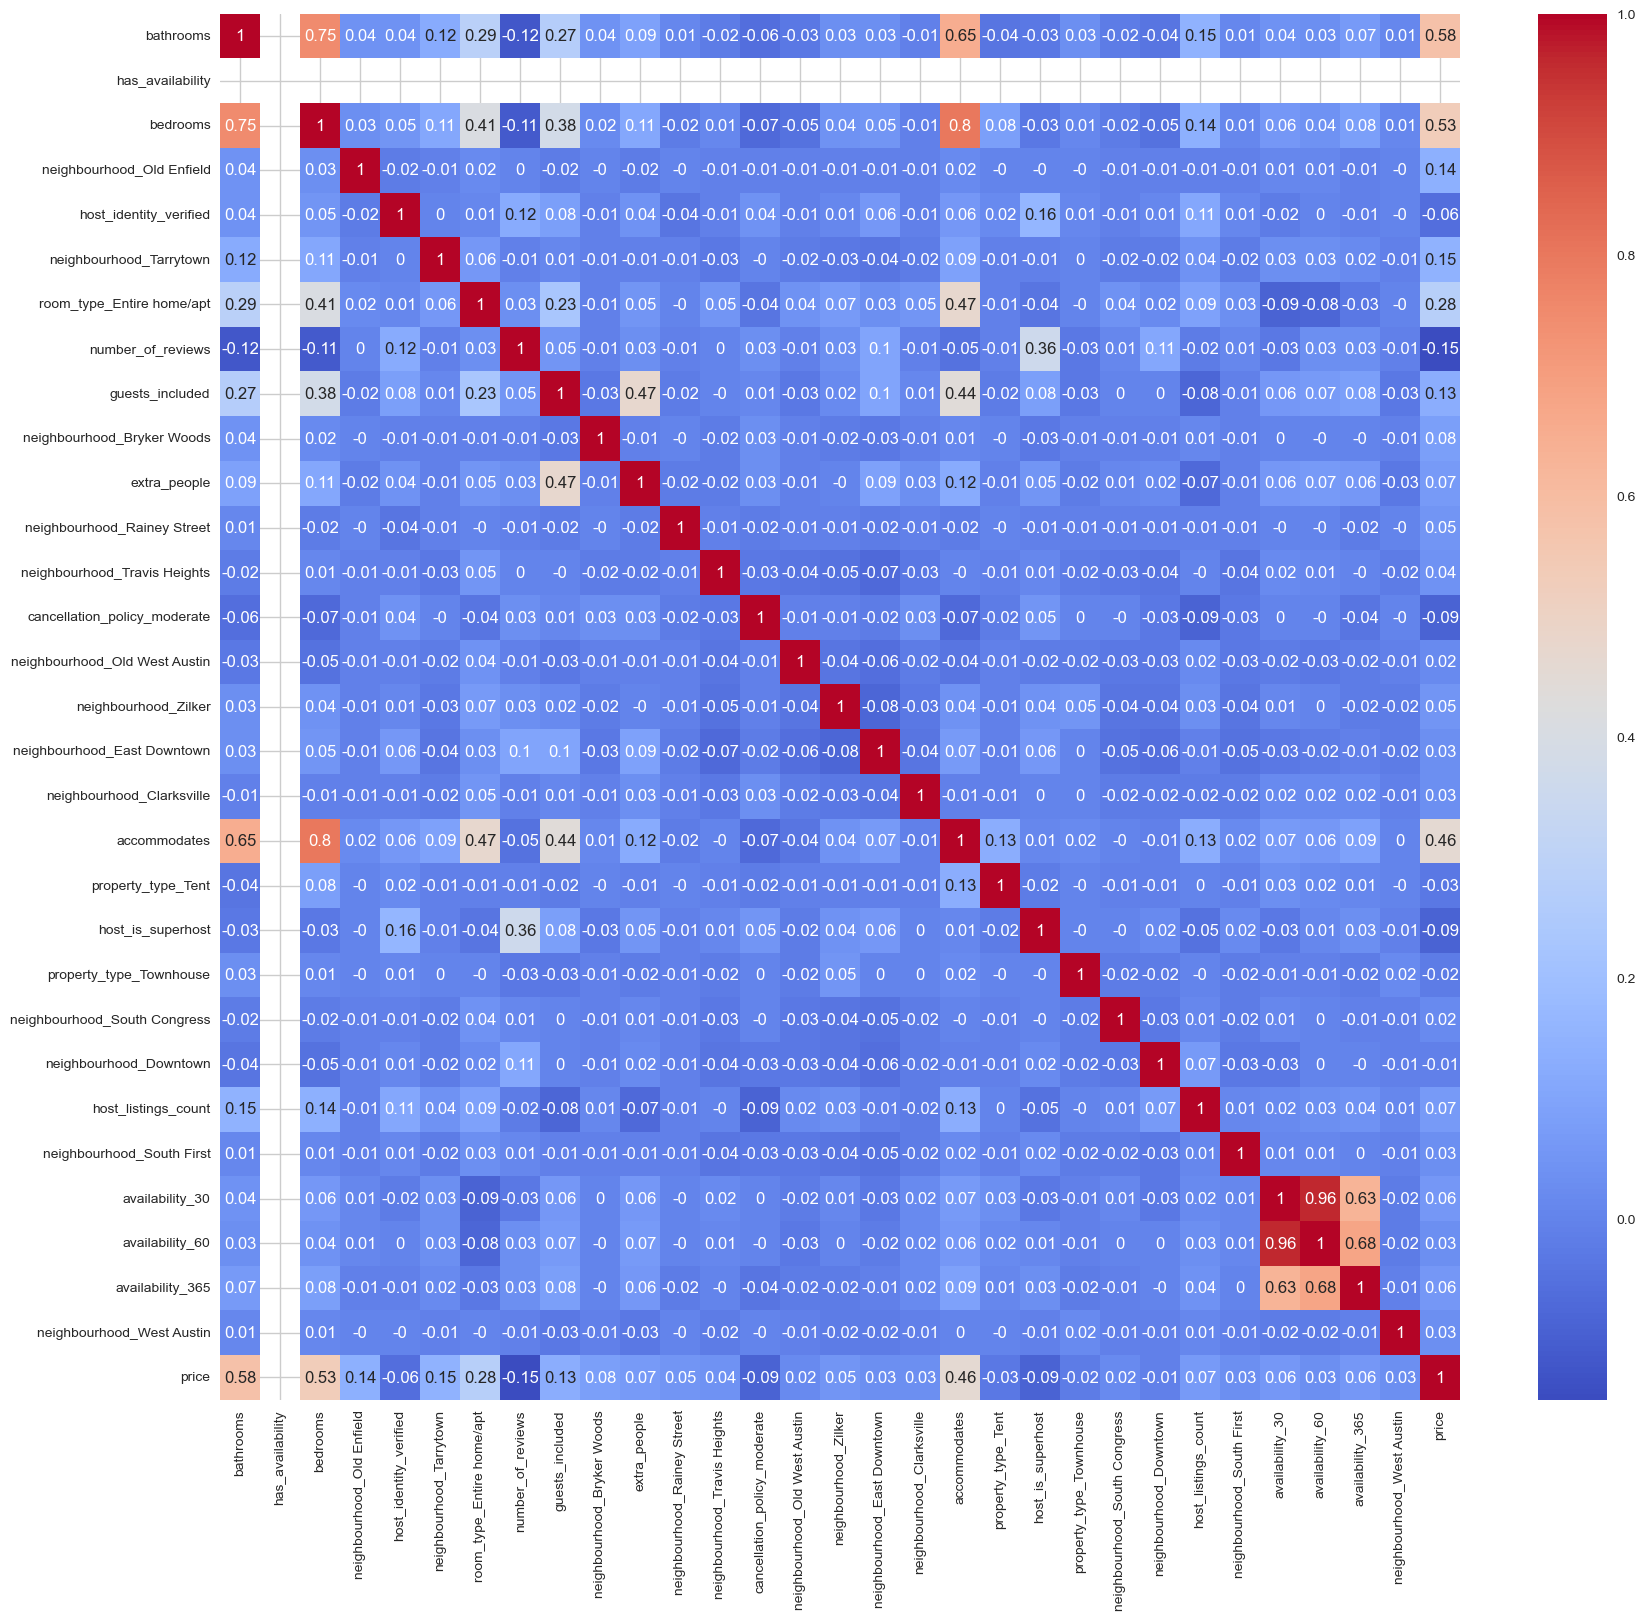

In [37]:
correlation_matrix = stepwise_df.corr()

correlation_matrix = correlation_matrix.round(2)

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [39]:
stepwise_df = stepwise_df.drop(columns=['accommodates', 'bedrooms', 'availability_30', 'availability_60'])

In [40]:
X = stepwise_df.drop(columns=['price'])
y = stepwise_df['price']
X = sm.add_constant(X)

log_reg = sm.OLS(y, X).fit()

print(log_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     130.4
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:34:11   Log-Likelihood:                -33987.
No. Observations:                4751   AIC:                         6.803e+04
Df Residuals:                    4725   BIC:                         6.819e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
bathrooms     